1. Pick a value of k and construct from each document the set of k-shingles. (lexical encoding)
Optionally, hash the k-shingles to shorter bucket numbers.
2. Sort the document-shingle pairs to order them by shingle.
3. Pick a length n for the minhash signatures. Feed the sorted list to the
algorithm of Section 3.3.5 to compute the minhash signatures for all the
documents.
4. Choose a threshold t that defines how similar documents have to be in
order for them to be regarded as a desired “similar pair.” Pick a number
of bands b and a number of rows r such that br = n, and the threshold
t is approximately (1/b)^(1/r). If avoidance of false negatives is important,
you may wish to select b and r to produce a threshold lower than t; if
speed is important and you wish to limit false positives, select b and r to
produce a higher threshold.
5. Construct candidate pairs by applying the LSH technique of Section 3.4.1.
6. Examine each candidate pair’s signatures and determine whether the fraction
of components in which they agree is at least t.

7. Optionally, if the signatures are sufficiently similar, go to the documents
themselves and check that they are truly similar, rather than documents
that, by luck, had similar signatures.

In [1]:
efficiency_SMS=0.98608
efficiency_Transaction=0.9900

In [2]:
print("Mobile Money Effciency Scores")
print(f"Mobile Money SMS: {efficiency_SMS}")
print(f"Mobile Money Transaction: {efficiency_Transaction}")

Mobile Money Effciency Scores
Mobile Money SMS: 0.98608
Mobile Money Transaction: 0.99


# TODO:
- create an encoding function
   -- TF IDF * word encoder
   -- Google USE (word,sentence and paragraph encoder)
   -- Other semantic encoding
- Create Minhashing function
  -- returns a numpy array of minhash signatures
- Create an LSH Module
  -- input a signature
  -- returns all signatures that are similar
- Compute similarity score This is done by averaging all the labels of all documents that are similar.

NB: shingling is the same like doing encoding. just that shingling does a lexical encoding but we rather need a semantic encoder and we need to make the rational into whether a word, sentence or paragraph encoding is better.

#TODO
- create an encoding function
-- TF IDF * word encoder
-- Google USE (word,sentence and paragraph encoder)
-- Other semantic encoding
- Create Minhashing function
-- returns a numpy array of minhash signatures
- Create an LSH Module
-- input a signature
-- returns all signatures that are similar
- Compute similarity score This is done by averaging all the labels of all documents that are similar.

NB: shingling is the same like doing encoding. just that shingling does a lexical encoding but we rather need a semantic encoder and we need to make the rational into whether a word, sentence or paragraph encoding is better.

## Hashing implementation steps
1. organize data into numpy array
2. compute weights for words, sentences, paragraphs using Google USE or TF IDF
3. Build a universal set of weights for all documents and calculate the standard deviation and mean for the set
4. build N hash functions where N is the size of a weighted document in which the hash function are generated randomly using a gaussian distribution with mean and standard deviation gotten from weight allocation scheme
5. Generate signatures for each document scheme (word,sentences or paragraph) by:
    a) multiplying each hash function by document(h.d) and if the result is >=0 we replace by 1 else replace by 0
    b) This will result in an N bit hash code for all documents
6. we then divide our signatures to B bands of r rows each
7. hash each band to an m-1 integer buckets following any of the hashing scheme below
    a) since each band represents k bit elements of (0 and 1) we can convert it to decimal representations ie let k signatures for document d1 =100 for k=3 it will be mapped to bucket of its decimal representation which is bucket 1
    b) or we should follow the exact hash function  ((ax+b) %p) %N
       where
          N is number of rows of the universal set
          P is any prime number bigger than N(usually the 1st prime after N)
          a and b are random integers such that 1<= a <=p-1 and 0 <= b <= p-1
          x is the row index


NB: Given  a new transaction we can query pass it though the transformation of 2-5 then proceed to calculate its hash integer in bucket and do only comparison between the element within thesame bucket.

## Testing simHash algorithm

## 1). Importing all the necessary libraries and packages

In [3]:
import numpy as np
import pandas as pd
import scipy

In [4]:
#data=pd.read_csv('../Dataset/SMS/spam.csv',delimiter=',',encoding='latin-1')
#message=data['v2']
#message=message[:100]
#data=pd.read_table('../Dataset/SMS/spam.csv',delimiter=',',encoding='latin-1')
data=pd.read_table('../Dataset/SMS/SMSSpamCollection.txt',names=['type','message'],encoding='latin-1')
#data=pd.read_table('../Dataset/SMS/real.csv',delimiter=',',encoding='latin-1')
#message=data['text']
message=data['message']
#message=data['v2']
print(message.shape)
data.head()
data.size


(5572,)


11144

In [5]:
newdata=data.loc[data['type']=="spam"]
newdata.shape

(747, 2)

## 2). [Encoding] Compute weights for words, sentences, paragraphs using Google USE or TF IDF

In [6]:
import tensorflow as tf
import tensorflow_hub as hub
embed=hub.load('./use/')

In [7]:
### Testing Embedding
word=["what is your age","how old are you","I love games","I love sports"]
embeddings = embed(word)

print(embeddings.shape)

(4, 512)


In [8]:

D = ['A group of kids is playing in a yard and an old man is standing in the background',
     'A group of children is playing in the house and there is no man standing in the background',
     'The young boys are playing outdoors and the man is smiling nearby']

from sklearn.feature_extraction.text import TfidfVectorizer

Tfi = TfidfVectorizer()
trans = Tfi.fit_transform(D)
#transT=trans.transform(['the'])
print(trans.shape)

(3, 24)


In [9]:
#testing cosine similarity measure for Google USE and TFIDF encodings

from sklearn.metrics.pairwise import cosine_similarity
x=embeddings[0]
y=embeddings[1]
print(cosine_similarity([x],[y]))
m=trans[0]
n=trans[1]
print(cosine_similarity(m,n))


[[0.80158687]]
[[0.65104035]]


In [10]:
def computeGoogleUSEWeights(messages):
    #input: an np array of words,sentences or paragraphs
    #output: an np array of weights

    #return Google USE encoded message
    return embed(messages)


In [11]:

#print(message)
encodedMSG=computeGoogleUSEWeights(message)
print(encodedMSG.shape)

(5572, 512)


In [12]:
print(encodedMSG)

tf.Tensor(
[[ 0.04297601 -0.01227703 -0.02205017 ... -0.05157935 -0.00527649
  -0.09759346]
 [-0.01459222  0.07797026 -0.03176386 ... -0.02766832  0.01186169
   0.04429685]
 [-0.0269872  -0.08973878  0.02013631 ... -0.06496149 -0.04696114
  -0.04437677]
 ...
 [-0.03499911  0.05832008  0.04978602 ... -0.00120977  0.03662091
  -0.04678824]
 [-0.05141344 -0.06940671  0.035317   ... -0.03163516  0.00932122
   0.03329109]
 [ 0.08013631  0.02865084 -0.04991435 ... -0.04258189  0.03531422
   0.00876346]], shape=(5572, 512), dtype=float32)


In [13]:
def TF_IDF_Encode(message,corpus):
    #incude the message data into the dataset before doing a TF IDF analysis of the result.
    message_corpus_set=np.hstack([corpus,message])
    Tfi = TfidfVectorizer()
    trans = Tfi.fit(message_corpus_set)
    return trans.fit_transform(message)

c=np.array(["good day","what is your a name","this is the live","good guy"])
m=np.array(["good man"])
print(TF_IDF_Encode(m,c))

  (0, 1)	0.7071067811865475
  (0, 0)	0.7071067811865475


##### when we have weights for messages or Transactions we can then represent them as points in an N-dimensional space

### 3).Build a universal set of weights for all documents and calculate the standard deviation and mean for the set

In [14]:
#declare a static variable called universalSet Containing weights for all our documents.
universalSet=np.array([]) #initially this universalSet is empty

def buildWeightsOfUniversalSet(weightedDocuments,universalSet):
    #input: a list of weighted documents coming from a TF IDF or google USE and the current UniversalSet of weights
    #output: a  universal set array from which, its mean and standard deviation and encoding size can be derived

    #universalSet=np.array([])
    for i in range(len(weightedDocuments)):
        #documentWeight=list(set(documentWeight[i]))
        #universalSet=np.hstack([universalSet,weightedDocuments[i]])
        universalSet=np.hstack([universalSet,weightedDocuments[i]])

    #return (universalSet.size//512, universalSet.mean(),np.sqrt(universalSet.var()))
    return universalSet


#testing code
universalSet=buildWeightsOfUniversalSet(encodedMSG,universalSet)
#This specifies the resulting encoding size for a given document
print(universalSet.shape)
encodingSize=512
Nbits=universalSet.size//encodingSize
mean=universalSet.mean()
std=np.sqrt(universalSet.var())
#Nbits,mean,std =buildWeightsOfUniversalSet(encodedMSG,universalSet)
print(Nbits,mean,std)

(2852864,)
5572 -3.770049370142058e-05 0.044194154967268084


## Drawing the Guassian normal distribution from which our random hash functions(hyper planes) are derived

<function matplotlib.pyplot.show(close=None, block=None)>

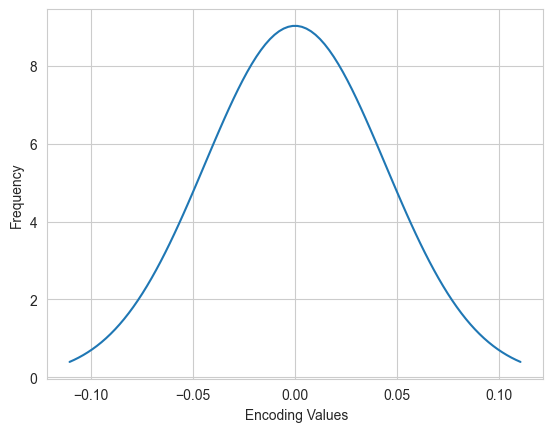

In [15]:
import matplotlib.pyplot as plt
import scipy.stats as stats


mu=mean
sigma=std
x=np.linspace(mu-2.5*sigma, mu + 2.5*sigma ,100)
plt.plot(x, stats.norm.pdf(x,mu,sigma))
plt.xlabel(" Encoding Values")
plt.ylabel("Frequency")
plt.show


In [16]:
# Generating random hash functions from the gaussian distribution
def generateHash(numHash,nbits,mean,std):
    #generates normal random numHash functions each of size nbits
    return np.random.normal(mean,std, size=(numHash,nbits))

#### 4). Build N hash functions of size nbits where N is the size of a weighted document in which the hash function are generated randomly using a Gaussian distribution with Mean and Standard Deviation gotten from weight allocation scheme including number of bits (nbits)

In [17]:
## Testing code
#storeHashes=generateHash(encodingSize,Nbits,mean,std)
#Nb: the encodingsize used for the numHash is just by considence we can generate the number of hash functions that we wish
storeHashes=generateHash(encodingSize,encodingSize,mean,std)
print(storeHashes.shape)

(512, 512)


In [18]:
print(encodingSize)
print(mean)
print(std)

hashFunctions=generateHash(4,6,mean,std)
print(hashFunctions)

512
-3.770049370142058e-05
0.044194154967268084
[[ 0.03064225 -0.06047448  0.05796973 -0.01028279 -0.00794878 -0.01055185]
 [-0.01787241 -0.03030392 -0.02529306 -0.0331359   0.01613614  0.00965339]
 [-0.00772352  0.00292373  0.08683907  0.06201103 -0.00167797 -0.01028971]
 [ 0.04416637  0.00691401 -0.02950944  0.02831223 -0.00220151 -0.0659375 ]]


In [19]:
print(encodedMSG.shape)
print(universalSet.shape[0]//512)

(5572, 512)
5572


### 5. Generate signatures for each document scheme (word,sentences or paragraph) by:
    a) multiplying each hash function by document(h.d) and if the result is >=0 we replace by 1 else replace by 0
    b) This will result in an N bit hash code for all documents


In [20]:
#Not Operational yet
def generateDocumentSignatureOnFly(documents):

    doc_bits=documents.shape[1]
    docTrans=documents.transpose()
    print(docTrans.shape)

    h=generateHash(1,doc_bits,0,1)
    return np.matmul(h,docTrans)



In [21]:
#this version generates the signature based on hashes stored in the storedHashes array
def signatureGenerator(documents,storeHashes):
    print(f"document shape---> {documents.shape}")
    print('------------')
    print(f"Hash shape---> {storeHashes.shape}")
    print('------------')

    #h=storeHashes.transpose()
    documents=np.array(documents)
    docTrans=documents.transpose()



    signature=np.matmul(storeHashes,docTrans)
    #we need to encode the signature into bits (ie 1's and 0's)
    bitsignature=np.array([1 if i>=0 else 0 for items in signature for i in items]) #results in a flattened array
    bitsignature=bitsignature.reshape(signature.shape) #reshape it back to original shape of signature array

    return bitsignature


signatureArray=signatureGenerator(encodedMSG,storeHashes)
print(signatureArray.shape)
print(signatureArray)

document shape---> (5572, 512)
------------
Hash shape---> (512, 512)
------------
(512, 5572)
[[0 1 0 ... 1 1 0]
 [1 1 1 ... 0 1 0]
 [0 0 0 ... 0 0 1]
 ...
 [0 1 1 ... 0 0 0]
 [1 1 1 ... 1 0 1]
 [0 0 1 ... 1 0 1]]


In [22]:
from sklearn.model_selection import train_test_split

#train, test =train_test_split(data,train_size=0.75,random_state=0)

#train=data
#test=data[30:40,:]
#x_train=train['text'][0:29,:]
#y_train=train['type'][0:29,:]
#x_test=test['text'][30:40,:]
#y_test=test['type'][30:40,:]

#x_train=train['text']
#x_train=x_train[0:29,:]
#print(x_train)
#y_train=train['type'][0:29,:]
#x_test=train['text'][30:40,:]
#y_test=train['type'][30:40,:]
#y_train=[1 if i=="spam" else 0 for i in y_train]
#y_test=[1 if i=="spam" else 0 for i in y_test]

#print(y_test)

In [23]:
train_sig=signatureArray.transpose()[0:30,:]
print(train_sig.shape)


(30, 512)


In [24]:
### Testing impart of signature with machine learning
#from sklearn.linear_model import LogisticRegression
#cls_lgr=LogisticRegression()
#cls_lgr.fit(train_sig,y_train)
#cls_lgr.predict(x_test[2])

In [25]:
#print(y_test)

In [26]:
#This function generates hashes on the fly as needed
def generateNbitSignatures(documents,mean,std):
    #input document which is an array of documents represented by their weights
    #output a Nbit(0's and 1's) signature representation of the document
    doc_bits=documents.shape[1]
    print(doc_bits)
    numDoc=documents.shape[0]
    signature=np.full((1,numDoc),1)

    docTrans=documents.transpose()

    #print(docTrans.shape)#512x100
    # iterate over all bits of each document applying a unique hash function generated on the fly
    for i in range(doc_bits):
        h=generateHash(1,doc_bits,mean,std)
        #print(h.shape)#1x512
        # generate signature by multiplying hash by the documents(H*D)
        #stack the generated signature per row of all documents to the final signature
        signature=np.vstack([signature,np.matmul(h,docTrans)])#1x512*512x1500
        #print(signature.shape)#1x1500

    #for cleaning purposes we eliminate the first rows since it is made of ones and was used to
    # define the shape of the signature array during declaration
    signature=signature[1:]

    #we need to encode the signature into bits (ie 1's and 0's)
    bitsignature=np.array([1 if i>=0 else 0 for items in signature for i in items]) #results in a flattened array
    bitsignature=bitsignature.reshape(signature.shape) #reshape it back to original shape of signature array


    return bitsignature

encodedMSG=np.array(encodedMSG)
print(encodedMSG.shape)
print("-------------------")
signatureMatrix=generateNbitSignatures(encodedMSG,mean,std)
print(signatureMatrix.shape)

(5572, 512)
-------------------
512
(512, 5572)


In [27]:
doc=embed(["how old are you",'america is a country'])
doc=np.array(doc)
#doc=doc.transpose()

stored=storeHashes

#print(np.matmul(stored,doc))

sig=signatureGenerator(doc,stored)
print(sig.tolist())


document shape---> (2, 512)
------------
Hash shape---> (512, 512)
------------
[[1, 0], [1, 0], [0, 1], [1, 0], [1, 0], [0, 0], [1, 1], [1, 1], [1, 0], [0, 1], [1, 1], [0, 0], [1, 1], [0, 1], [1, 1], [1, 1], [0, 1], [1, 1], [0, 0], [0, 0], [1, 0], [1, 1], [1, 0], [0, 1], [0, 1], [0, 0], [0, 1], [0, 0], [0, 1], [0, 0], [1, 0], [1, 1], [1, 1], [0, 1], [0, 0], [0, 0], [0, 1], [1, 1], [0, 0], [1, 1], [1, 0], [0, 1], [0, 1], [0, 1], [1, 1], [1, 1], [0, 1], [0, 1], [1, 0], [1, 0], [0, 0], [0, 1], [1, 1], [0, 0], [1, 0], [0, 0], [0, 1], [0, 1], [1, 1], [0, 1], [1, 0], [1, 1], [1, 0], [0, 0], [0, 1], [1, 1], [0, 1], [1, 0], [1, 1], [1, 0], [0, 0], [1, 0], [0, 1], [0, 1], [1, 1], [0, 0], [1, 0], [0, 0], [1, 1], [1, 1], [0, 1], [1, 0], [1, 0], [1, 0], [1, 1], [1, 1], [1, 0], [1, 0], [0, 0], [0, 1], [1, 0], [0, 1], [0, 1], [1, 1], [1, 1], [0, 0], [0, 0], [0, 1], [0, 1], [0, 0], [1, 0], [1, 1], [1, 1], [1, 1], [1, 1], [1, 0], [1, 1], [1, 1], [1, 0], [0, 0], [0, 1], [0, 0], [0, 0], [0, 1], [1, 0],

### 6. We then divide our signatures to B bands of r rows each


In [28]:
Nbsignature=generateNbitSignatures(encodedMSG,mean,std)

print(Nbsignature)
print(signatureArray)


512
[[1 0 1 ... 0 1 0]
 [1 0 0 ... 0 0 1]
 [1 0 1 ... 0 1 0]
 ...
 [1 1 1 ... 1 0 0]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 0 1]]
[[0 1 0 ... 1 1 0]
 [1 1 1 ... 0 1 0]
 [0 0 0 ... 0 0 1]
 ...
 [0 1 1 ... 0 0 0]
 [1 1 1 ... 1 0 1]
 [0 0 1 ... 1 0 1]]


In [29]:
def split(signature,numBands:int):
    #assert that the entire signature can be divided into bands of equal length
    assert len(signature)%numBands==0
    # creating a placeholder to hold values for the subvector
    subvect=[]

    count=0
    r=len(signature)//numBands
    #loop through the signature matrix while moving r steps
    for i in range(0,len(signature),r):
        subvect.append(signature[i:i+r])
        count+=1

    print(count)
    return subvect

#print(split(Nbsignature,64))

print(str(25))

25


# Splitting to number of Bands

In [30]:
b=16
subvects=split(signatureArray,b)

print(len(subvects))
print(f"Number of Bands:==> {b}")
print(f"Number of rows per band:==> {512//b}")
print(f"Number of Buckets:==> {2**(512//b)} ")


16
16
Number of Bands:==> 16
Number of rows per band:==> 32
Number of Buckets:==> 4294967296 


In [31]:
#bands={}
def DecimalHashBandsIntoBucket(BandVect:list):
    bands={}
    for j in range(len(BandVect)):

        for i in range(BandVect[j].shape[1]):
            subsig=BandVect[j][:,i]
            #converting list of arrays to string
            strSubsig=''.join(str(x) for x in subsig)

            #converting binary to decimal representation
            bandID=int(strSubsig,2)

            if bandID not in bands.keys():
                bands[bandID]=[i]
            else:
                bands[bandID].append(i)
    return bands

DecimalHashBandsIntoBucket(subvects)

bands=DecimalHashBandsIntoBucket(subvects)
print(bands)


{1135441094: [0], 3360192419: [1], 1374864467: [2, 1163], 1494116003: [3], 445412582: [4], 456837075: [5], 372791333: [6], 2674716305: [7, 103, 154], 405308100: [8, 4281], 2542059732: [9, 4162], 2610625831: [10], 573646291: [11, 3229], 271374039: [12, 5285], 2340081015: [13], 1483951957: [14], 388092209: [15], 4199339879: [16], 518804835: [17], 2569663747: [18], 3687905063: [19], 497898921: [20], 2588857047: [21], 160256711: [22], 1171399911: [23], 2612194935: [24], 352146803: [25], 3635311749: [26], 2672334443: [27], 486175842: [28], 3108590849: [29], 2601305110: [30], 398079859: [31], 3153806769: [32], 3610002706: [33], 2598424979: [34], 567964758: [35], 3631929157: [36], 338633517: [37], 3654413477: [38], 2658328163: [39], 4209690242: [40], 2557235202: [41], 527718103: [42], 758319657: [43], 4216048869: [44], 2464979493: [45, 326, 1988], 187669766: [46], 4178830769: [47], 2658309955: [48], 2653822053: [49], 1001945137: [50], 2366543599: [51], 292603346: [52], 2668254211: [53], 55069

In [32]:
from itertools import combinations
# Generate a list of tuples containing just candidate pairs
def generateCandidatePairs(bands):
    #input: A bucket(dictionary) of bands with various candidates
    #Output: A list of tuples containing pairs of candidates
    candidatepairs=[]
    #extract values from bands that constitute a bucket
    candidates=bands.values()

    for candidate in candidates:
        if len(candidate)<=1: continue

        candidatepairs.extend(combinations(candidate,2))

    return list(set(candidatepairs))

#print(signatureMatrix[1:10,:])
#print(signatureMatrix[1:10,:].transpose())


candidatesPairs=generateCandidatePairs(bands)
print(candidatesPairs)

[(2305, 3458), (2322, 4859), (5423, 5558), (2623, 2721), (57, 768), (493, 2912), (2089, 4592), (2524, 5423), (1853, 3189), (444, 2646), (339, 1132), (4014, 4498), (2522, 2646), (4128, 5423), (1470, 4556), (1935, 4655), (1567, 4259), (2014, 4948), (1319, 4014), (1925, 4498), (207, 1134), (2524, 3594), (167, 3807), (2387, 3625), (223, 1981), (2280, 4173), (983, 4329), (3101, 4694), (965, 2740), (424, 2910), (1483, 4014), (2808, 5460), (357, 4577), (424, 1598), (1942, 4299), (702, 3534), (3534, 5191), (240, 879), (1585, 5458), (1281, 4638), (1989, 2280), (4184, 5458), (2325, 5469), (223, 1585), (2385, 3534), (1427, 3156), (287, 2509), (967, 2762), (1902, 2518), (3311, 4638), (1738, 2266), (3833, 5357), (2518, 4184), (1989, 2522), (3211, 3324), (1413, 1508), (1470, 2982), (441, 1003), (2681, 3280), (1989, 4184), (1273, 4014), (1483, 4498), (880, 4348), (2338, 2797), (1560, 3549), (3189, 4918), (57, 339), (455, 3009), (1196, 3272), (1413, 2712), (3051, 3492), (339, 1485), (1385, 4456), (374

## Optimizing bands and visualization
 -- this constitute use selecting at random some signatures and verifying  if they are candidate pairs or not
 -- if they are candidates we plot at point 1 if not then their candidate statue is 0


In [33]:


from sklearn.metrics.pairwise import  cosine_similarity

pairs=pd.DataFrame({
    'x':[],
    'y':[],
    'cosine':[],
    'candidates':[]
})
signatureMatrixTrans=Nbsignature.transpose()
data_len=encodedMSG.shape[0]
print(data_len)
sampleSize=500
choosen=set()

for _ in range(sampleSize):
    x,y=np.random.choice(data_len,2)
    if x==y or (x,y) in choosen: continue
    choosen.add((x,y))
    candidates=1 if (x,y) in candidatesPairs else 0

    vectorX=signatureMatrixTrans[x]

    vectorY=signatureMatrixTrans[y]

    cosine=cosine_similarity([vectorX],[vectorY])[0][0]
    #if cosine>0.75 and candidates==0: continue

    pairs=pairs.append({
        'x':x,
        'y':y,
        'cosine':cosine,
        'candidates':candidates
    },ignore_index=True)

cos_Min=pairs['cosine'].min()
cos_Max=pairs['cosine'].max()

pairs['cosine_norm'] = (pairs['cosine'] -cos_Min)/(cos_Max - cos_Min)




5572


C:\Users\Cyanide Inc\AppData\Local\Temp\ipykernel_14776\3781163753.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairs=pairs.append({
C:\Users\Cyanide Inc\AppData\Local\Temp\ipykernel_14776\3781163753.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairs=pairs.append({
C:\Users\Cyanide Inc\AppData\Local\Temp\ipykernel_14776\3781163753.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairs=pairs.append({
C:\Users\Cyanide Inc\AppData\Local\Temp\ipykernel_14776\3781163753.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pairs=pairs.append({
C:\Users\Cyanide Inc\AppData\Local\Temp\ipykernel_14776\3781163753.py:28: Future

<AxesSubplot: xlabel='cosine', ylabel='candidates'>

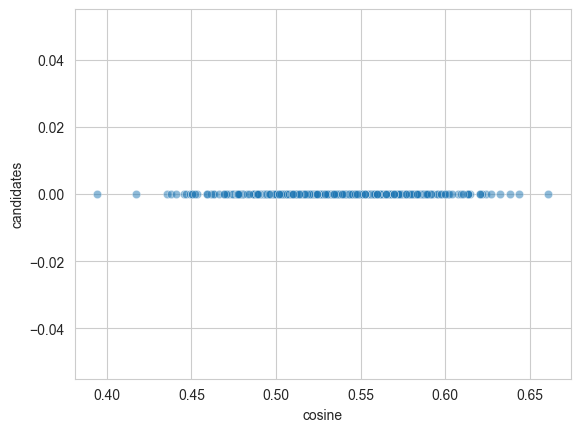

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data=pairs, x='cosine', y='candidates', alpha=0.5)

In [35]:

print(pairs['candidates'].sum())

0.0


In [36]:
import seaborn as sns

In [37]:
res=[]
def optimalGraph():
    pairs=pd.DataFrame({
        'x':[],
        'y':[],
        'cosine':[],
        'candidates':[]
    })

    signatureMatrixTrans=Nbsignature.transpose()
    data_len=encodedMSG.shape[0]

    sampleSize=500
    choosen=set()

    for _ in range(sampleSize):
        x,y=np.random.choice(data_len,2)
        if x==y or (x,y) in choosen: continue
        choosen.add((x,y))
        candidates=1 if (x,y) in candidatesPairs else 0

        vectorX=signatureMatrixTrans[x]

        vectorY=signatureMatrixTrans[y]

        cosine=cosine_similarity([vectorX],[vectorY])[0][0]

        pairs=pairs.append({
            'x':x,
            'y':y,
            'cosine':cosine,
            'candidates':candidates
        },ignore_index=True)

    print(pairs['candidates'].sum())
    res.append(pairs['candidates'].sum())
    cos_Min=pairs['cosine'].min()
    cos_Max=pairs['cosine'].max()

    pairs['cosine_norm'] = (pairs['cosine'] -cos_Min)/(cos_Max - cos_Min)

   # print(data_len*0.01)
    #print(data_len*0.01)



In [38]:
#while pairs['candidates'].sum()<100:
#    sns.scatterplot(data=pairs, x='cosine', y='candidates', alpha=0.5)
#    optimalGraph()



In [39]:

#print(max(res))

<AxesSubplot: xlabel='cosine_norm', ylabel='candidates'>

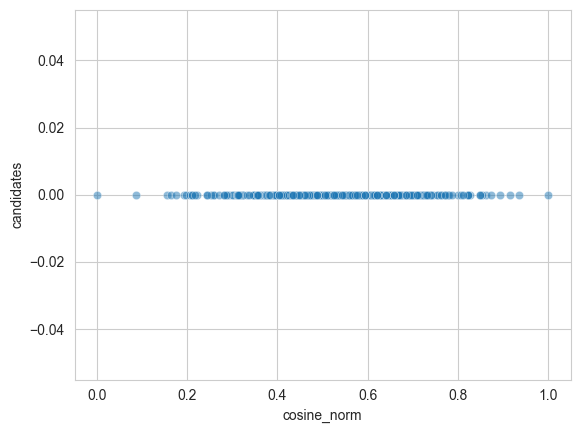

In [40]:
sns.scatterplot(data=pairs, x='cosine_norm', y='candidates', alpha=0.5)

In [41]:
def factors(m):
    i=1
    while i<=m:
        if m%i==0: print(f"if B=={i}--->{512/i} rows per buckets",)
        i+=1

factors(512)

if B==1--->512.0 rows per buckets
if B==2--->256.0 rows per buckets
if B==4--->128.0 rows per buckets
if B==8--->64.0 rows per buckets
if B==16--->32.0 rows per buckets
if B==32--->16.0 rows per buckets
if B==64--->8.0 rows per buckets
if B==128--->4.0 rows per buckets
if B==256--->2.0 rows per buckets
if B==512--->1.0 rows per buckets


### 7. hash each band to an m-1 integer buckets following any of the hashing scheme below



Now, this is an interesting way to visualize our distribution, but we have reason. We can actually tune our LSH function using b, and we have a formalized function that tells us the probability of identifying a pair as candidate pairs given their similarity. We calculate this as so:

In [42]:
def probability(s, r, b):
    # s: similarity
    # r: rows (per band)
    # b: number of bands
    return 1 - (1 - s**r)**b

def normalize(x, x_min, x_max):
    return (x - x_min) / (x_max - x_min)

def treshold(r,b):
    return (1/b)**(1/r)

Let’s visualize that for our current parameters, alongside our scatter plot.

Probability:--> 0.008988187880539789
treshold(t):--> 0.8052451659746271


<AxesSubplot: xlabel='cosine_norm', ylabel='candidates'>

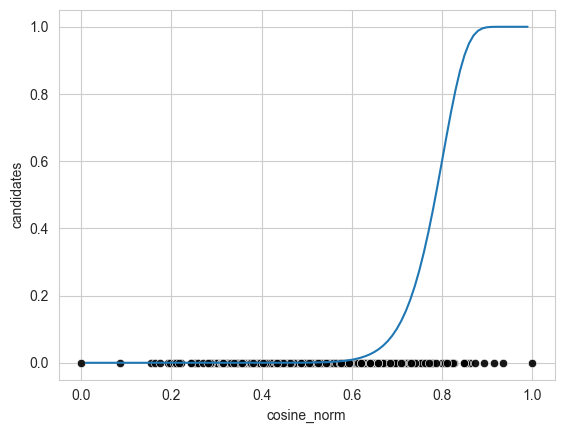

In [43]:
b = 32
r = int(512 / b)
s_scores = np.arange(0.01, 1, 0.01)
P_scores = [probability(s, r, b) for s in s_scores]

print(f"Probability:--> {probability(0.6,r,b)}")

print(f"treshold(t):--> {treshold(r,b)}")

sns.lineplot(x=s_scores, y=P_scores)
sns.scatterplot(data=pairs, x='cosine_norm', y='candidates', alpha=0.9, color='k')

In [44]:
print(candidates)

0


<AxesSubplot: xlabel='cosine', ylabel='candidates'>

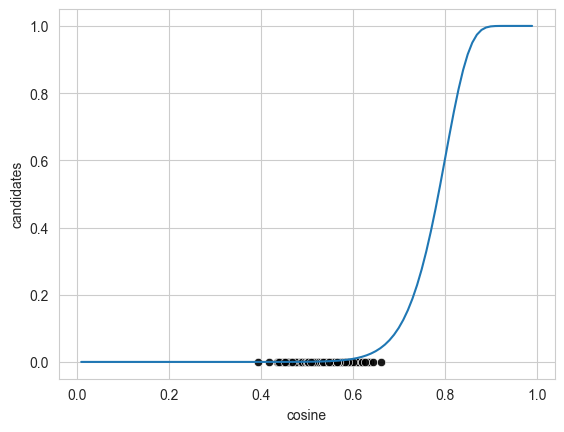

In [45]:
sns.lineplot(x=s_scores, y=P_scores,legend="full")
sns.scatterplot(data=pairs, x='cosine', y='candidates', alpha=0.9, color='k')

## testing different band sizes and their corresponding step functon

C:\Users\Cyanide Inc\AppData\Local\Temp\ipykernel_14776\2410221718.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  probs = probs.append(pd.DataFrame({
C:\Users\Cyanide Inc\AppData\Local\Temp\ipykernel_14776\2410221718.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  probs = probs.append(pd.DataFrame({
C:\Users\Cyanide Inc\AppData\Local\Temp\ipykernel_14776\2410221718.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  probs = probs.append(pd.DataFrame({
C:\Users\Cyanide Inc\AppData\Local\Temp\ipykernel_14776\2410221718.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  probs = probs.append(pd.DataFrame({
C:\Users\Cyanide Inc

[Text(0.5, 1.0, 'Similarity to Probability S-Curve for mobile money SMS')]

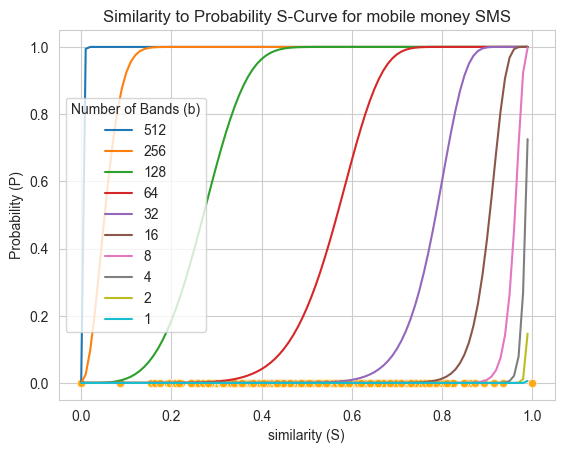

In [46]:
probs=pd.DataFrame({
    'P':[],
    's':[],
    'b':[]
})
for b in [512,256,128,64,32,16,8,4,2,1]:
    r = int(512 / b)
    s_scores = np.arange(0.0, 1, 0.01)
    P_scores = [probability(s, r, b) for s in s_scores]
    probs = probs.append(pd.DataFrame({
        'Probability (P)': P_scores,
        'similarity (S)': s_scores,
        'Number of bands': [str(b)]*len(s_scores)
    }), ignore_index=True)

linegraph=sns.lineplot(data=probs, x='similarity (S)', y='Probability (P)', hue='Number of bands')
sns.scatterplot(data=pairs, x='cosine_norm', y='candidates', alpha=0.9, color='orange')
linegraph.legend_.set_title("Number of Bands (b)")
linegraph.set(title="Similarity to Probability S-Curve for mobile money SMS")

In [47]:
print(bands)

{1135441094: [0], 3360192419: [1], 1374864467: [2, 1163], 1494116003: [3], 445412582: [4], 456837075: [5], 372791333: [6], 2674716305: [7, 103, 154], 405308100: [8, 4281], 2542059732: [9, 4162], 2610625831: [10], 573646291: [11, 3229], 271374039: [12, 5285], 2340081015: [13], 1483951957: [14], 388092209: [15], 4199339879: [16], 518804835: [17], 2569663747: [18], 3687905063: [19], 497898921: [20], 2588857047: [21], 160256711: [22], 1171399911: [23], 2612194935: [24], 352146803: [25], 3635311749: [26], 2672334443: [27], 486175842: [28], 3108590849: [29], 2601305110: [30], 398079859: [31], 3153806769: [32], 3610002706: [33], 2598424979: [34], 567964758: [35], 3631929157: [36], 338633517: [37], 3654413477: [38], 2658328163: [39], 4209690242: [40], 2557235202: [41], 527718103: [42], 758319657: [43], 4216048869: [44], 2464979493: [45, 326, 1988], 187669766: [46], 4178830769: [47], 2658309955: [48], 2653822053: [49], 1001945137: [50], 2366543599: [51], 292603346: [52], 2668254211: [53], 55069

In [48]:
# we define a bucket class that holds a bucket ID and a list of elements for each ID
# bucket should get methods like
#   - insert element
#   - get elements
#   - get bucket size
#   - get elements
#   - get elements

class Buckets:
    bucketID =None
    elements = {}
    def __int__(self,ID):
        self.bucketID=ID

    def insertElement(self,ID,element):
        self.elements.insert(element,)

    def getElements(self,ID):
        return self.elements


#### a) Since each band represents k bit elements of (0 and 1) we can convert it to decimal representations ie let k signatures for document d1 =100 for k=3 it will be mapped to bucket of its decimal representation which is bucket 1

#### b) or we should follow the exact hash function  ((ax+b) %p) %N
       where
          N is number of rows of the universal set
          P is any prime number bigger than N(usually the 1st prime after N)
          a and b are random integers such that 1<= a <=p-1 and 0 <= b <= p-1
          x is the row index


### NB: Given  a new transaction we can query pass it though the transformation of 2-5 then proceed to calculate its hash integer in bucket and do only comparison between the element within thesame bucket.

In [49]:
a=np.array([1,2,3,4])
np.stack([3,5,7,8])

print(a)

[1 2 3 4]


## Testing LSH Methodology

### A) Take in a  message as input

In [64]:
m1=["You are receiving this message because you account has been hacked. Kindly call this number 0551084599 so we help you"]
m=["Send money for Free to ALL NET-WORKS via Voda-fone Cash. Dial *110# and select option 1 to trans-fer money for free."]

### B) Encode the message using thesame encoding scheeme used in training

In [65]:
embM=embed(m)
print(embM)

tf.Tensor(
[[-4.26583365e-02 -7.74879605e-02  5.72723895e-03  4.48964797e-02
   7.35532939e-02 -3.37276496e-02 -3.33068706e-02  3.48043144e-02
  -5.16925268e-02 -8.11613202e-02 -6.04705326e-02 -3.13415006e-02
   1.05125522e-02 -5.08906208e-02  6.83588013e-02  4.79507744e-02
  -6.92597358e-03 -7.12566152e-02  3.19215208e-02  7.00092763e-02
  -3.00549790e-02 -3.15404981e-02  7.13603720e-02  4.83835191e-02
  -1.51434587e-02  4.10013050e-02  5.79556525e-02  2.07281373e-02
  -4.61740717e-02 -1.39005082e-02  5.75841703e-02 -4.80644181e-02
  -1.87143721e-02 -3.34948488e-02 -3.74918361e-03 -3.14378515e-02
   1.74619239e-02  1.24898013e-02 -4.72511053e-02  5.68121746e-02
   5.40523492e-02 -4.51990403e-02 -6.95962831e-02 -3.22240479e-02
   3.71783674e-02 -5.68794608e-02  3.77144106e-02 -3.16574611e-02
  -1.75390653e-02 -3.30118239e-02 -3.25455032e-02 -3.24180126e-02
  -6.92014471e-02  2.31743325e-02  1.53362826e-02 -2.39848141e-02
   2.05266867e-02 -3.40288803e-02 -5.56637459e-02 -3.18585858e-02

### C) Generate transaction signature using the same signature generation mechanism used during training
  --NB: using another signature generation mechanism (Hash functions) will completely destroy the entire idea

In [66]:
sigEmbMsg=signatureGenerator(embM,storeHashes)
print(sigEmbMsg)

document shape---> (1, 512)
------------
Hash shape---> (512, 512)
------------
[[1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]


### D) pass it through has DLSH so it can be mapped to a particular bucket or set of bucket(s)


##### - split signature to **B** bands of **r** rows each (the same as that used during training)

In [67]:
b=16
print(b)
splitMsg=split(sigEmbMsg,b)
print(splitMsg)

16
16
[array([[1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1]]), array([[1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0]]), array([[1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
     

##### - Hash bands of the message's signature into buckets

In [68]:

def ItemDecimalHashBandsIntoBucket(BandVect:list):
    #input: singature split into B bands
    #output: buckets to which the transaction hashes into
    myBuckets=[]
    for j in range(len(BandVect)):
        for i in range(BandVect[j].shape[1]):
            subsig=BandVect[j][:,i]
            #converting list of arrays to string
            strSubsig=''.join(str(x) for x in subsig)

            #converting binary to decimal representation
            bandID=int(strSubsig,2)

            myBuckets.append(bandID)


    return myBuckets


print(ItemDecimalHashBandsIntoBucket(splitMsg))

[2300843089, 3893603326, 4218121274, 569535169, 4169593874, 3011702687, 861195979, 1684508908, 2706630288, 3003249837, 812072809, 4175884370, 2317527703, 3314091130, 1249143732, 2110570037]


### E) Extract all the candidate pairs in the buckets to which our transaction has been hashed to

In [69]:
msgbuckets=ItemDecimalHashBandsIntoBucket(splitMsg)

def extractCandidates(msgbuckets,bands):
    #input: bucket ID
    #output: candidates within the bucket
    candidates=[]
    for items in msgbuckets:
        if items in bands.keys():
            candidates.append(bands[items])
    candidatesFlat=[i for sublist in candidates for i  in sublist]

    return candidatesFlat


extractedCan=extractCandidates(msgbuckets,bands)
print(bands)

{1135441094: [0], 3360192419: [1], 1374864467: [2, 1163], 1494116003: [3], 445412582: [4], 456837075: [5], 372791333: [6], 2674716305: [7, 103, 154], 405308100: [8, 4281], 2542059732: [9, 4162], 2610625831: [10], 573646291: [11, 3229], 271374039: [12, 5285], 2340081015: [13], 1483951957: [14], 388092209: [15], 4199339879: [16], 518804835: [17], 2569663747: [18], 3687905063: [19], 497898921: [20], 2588857047: [21], 160256711: [22], 1171399911: [23], 2612194935: [24], 352146803: [25], 3635311749: [26], 2672334443: [27], 486175842: [28], 3108590849: [29], 2601305110: [30], 398079859: [31], 3153806769: [32], 3610002706: [33], 2598424979: [34], 567964758: [35], 3631929157: [36], 338633517: [37], 3654413477: [38], 2658328163: [39], 4209690242: [40], 2557235202: [41], 527718103: [42], 758319657: [43], 4216048869: [44], 2464979493: [45, 326, 1988], 187669766: [46], 4178830769: [47], 2658309955: [48], 2653822053: [49], 1001945137: [50], 2366543599: [51], 292603346: [52], 2668254211: [53], 55069

### F) Evaluate their corresponding label for spam or not (1 or 0) then evaluate the average

In [56]:

predictions=data['type']
#s=predictions[4:12]
#print(s)
#this is a global variable we always need to use
encodedPredictions=[1 if item=="spam" else 0 for item in predictions]
#print(encodedPredictions)
print(extractedCan)

[]


In [57]:
predictions
encodedPredictions=[1 if item=="spam" else 0 for item in predictions]
print(encodedPredictions)

[0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [58]:
print(f"Message:--> {m}")
for i in extractedCan:
    print("-------------------------------")
    print(i)
    print(message[i])
    print("-------------------------------")
    print(encodedPredictions[i])



Message:--> ['MTN is updating all user information and require you to call 0243238543']


### G) based on some treshold T we can conclude if it a spam or not

In [59]:

def isFraud(extractCan):
    count=len(extractCan)
    sum=0
    for i in extractCan:
        sum+=encodedPredictions[i]

    assert count>0
    #return sum/count
    return np.average((encodedPredictions))
print(encodedPredictions)

[0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [60]:
def fitness_score(encodedPredictions):
    return np.average((encodedPredictions)) *6.5

In [61]:
print(f"Overall Fraud Score: {fitness_score(encodedPredictions)}")

Overall Fraud Score: 0.8714106245513281


In [62]:
def treshold_fitness_extractor(f_score):
    if (f_score >= 0.8):
        return 1
    else:
        return 0

In [63]:
f_score = fitness_score(encodedPredictions)
print(f"Treshold_Fitness_Extractor Score: {treshold_fitness_extractor(f_score)}")

Treshold_Fitness_Extractor Score: 1
